Epoch 1/20, Loss: 0.6954, Gradient Norm: 0.0647
Epoch 2/20, Loss: 0.6948, Gradient Norm: 0.0550
Epoch 3/20, Loss: 0.6942, Gradient Norm: 0.0417
Epoch 4/20, Loss: 0.6932, Gradient Norm: 0.0112
Epoch 5/20, Loss: 0.6933, Gradient Norm: 0.0123
Epoch 6/20, Loss: 0.6936, Gradient Norm: 0.0241
Epoch 7/20, Loss: 0.6936, Gradient Norm: 0.0256
Epoch 8/20, Loss: 0.6935, Gradient Norm: 0.0207
Epoch 9/20, Loss: 0.6933, Gradient Norm: 0.0125
Epoch 10/20, Loss: 0.6932, Gradient Norm: 0.0034
Epoch 11/20, Loss: 0.6932, Gradient Norm: 0.0050
Epoch 12/20, Loss: 0.6932, Gradient Norm: 0.0112
Epoch 13/20, Loss: 0.6933, Gradient Norm: 0.0144
Epoch 14/20, Loss: 0.6933, Gradient Norm: 0.0145
Epoch 15/20, Loss: 0.6933, Gradient Norm: 0.0121
Epoch 16/20, Loss: 0.6932, Gradient Norm: 0.0082
Epoch 17/20, Loss: 0.6932, Gradient Norm: 0.0037
Epoch 18/20, Loss: 0.6931, Gradient Norm: 0.0007
Epoch 19/20, Loss: 0.6932, Gradient Norm: 0.0043
Epoch 20/20, Loss: 0.6932, Gradient Norm: 0.0070


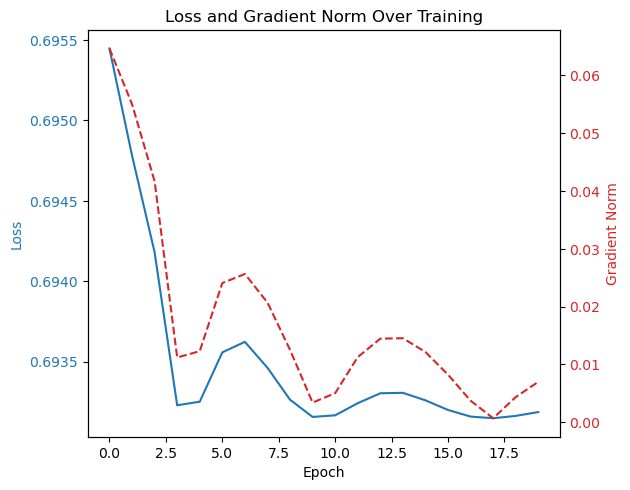

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Sample dataset (benign = 0, malicious = 1)
urls = [
    ("google.com", 0),
    ("facebook.com", 0),
    ("bank-login-secure.com", 1),
    ("paypal-security-alert.com", 1),
    ("github.com", 0),
    ("free-money-now.biz", 1)
]

# Character set
CHARACTERS = "abcdefghijklmnopqrstuvwxyz0123456789.-/"
CHAR_TO_INDEX = {char: i+1 for i, char in enumerate(CHARACTERS)}  # 1-based indexing
INDEX_TO_CHAR = {i: char for char, i in CHAR_TO_INDEX.items()}
VOCAB_SIZE = len(CHARACTERS) + 1  # Extra for padding

# Hyperparameters
SEQ_LEN = 50  # Max length of URL
EMBEDDING_DIM = 16
HIDDEN_DIM = 32
NUM_LAYERS = 2
LEARNING_RATE = 0.005
EPOCHS = 20

# Convert URLs to numerical sequences
def encode_url(url, seq_len=SEQ_LEN):
    encoded = [CHAR_TO_INDEX.get(char, 0) for char in url]  # Convert to numbers
    padded = encoded[:seq_len] + [0] * (seq_len - len(encoded))  # Pad/truncate
    return torch.tensor(padded, dtype=torch.long)

# Prepare dataset
X = torch.stack([encode_url(url, SEQ_LEN) for url, _ in urls])
y = torch.tensor([label for _, label in urls], dtype=torch.long)

# Define Character-level LSTM Model
class URLClassifierLSTM(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_layers):
        super(URLClassifierLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 2)  # Output 2 classes (benign/malicious)
    
    def forward(self, x):
        x = self.embedding(x)  # Convert indices to embeddings
        lstm_out, _ = self.lstm(x)  # LSTM forward pass
        last_output = lstm_out[:, -1, :]  # Take last output
        return self.fc(last_output)  # Fully connected layer

# Instantiate model
model = URLClassifierLSTM(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM, NUM_LAYERS)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE) # you can try changing the optimizer.

# Training loop with gradient monitoring
losses = []
gradients = []

for epoch in range(EPOCHS):
    optimizer.zero_grad()
    
    outputs = model(X)
    loss = criterion(outputs, y)
    loss.backward()
    
    # Monitor gradient norms
    total_norm = 0
    for p in model.parameters():
        if p.grad is not None:
            total_norm += p.grad.norm().item() ** 2
    total_norm = np.sqrt(total_norm)
    gradients.append(total_norm)
    
    optimizer.step()
    
    losses.append(loss.item())
    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {loss.item():.4f}, Gradient Norm: {total_norm:.4f}")

# Plot loss and gradients
fig, ax1 = plt.subplots()

ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss", color="tab:blue")
ax1.plot(range(EPOCHS), losses, color="tab:blue", label="Loss")
ax1.tick_params(axis="y", labelcolor="tab:blue")

ax2 = ax1.twinx()
ax2.set_ylabel("Gradient Norm", color="tab:red")
ax2.plot(range(EPOCHS), gradients, color="tab:red", linestyle="dashed", label="Gradient Norm")
ax2.tick_params(axis="y", labelcolor="tab:red")

fig.tight_layout()
plt.title("Loss and Gradient Norm Over Training")
plt.show()
